In [36]:
import sys
sys.path.append('../utils')

from preprocessing import Preprocessor

import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np
import random
#from sklearn.model_selection import train_test_split  
from sklearn.cross_validation import train_test_split
from PIL import Image

import tensorflow as tf
import tensorflow.contrib.layers as layers
tf.python.control_flow_ops = tf

## Initialise the data

In [37]:
train_cats, train_dogs, train_all, test_all = Preprocessor.get_dataset_paths()

random.seed(42)
tf.set_random_seed(42)

np.random.shuffle(train_all)
np.random.shuffle(test_all)

labels = [[1., 0.] if 'dog' in name else [0., 1.] for name in train_all] # labels are one hot encoded

## Example of usage

<PIL.Image.Image image mode=RGB size=64x64 at 0x7F6E06C8C850>
[1.0, 0.0]


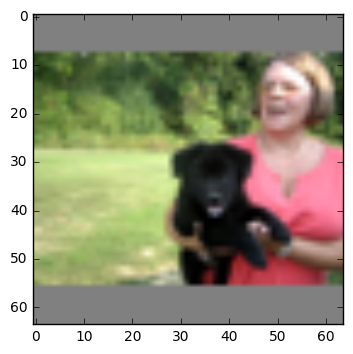

In [38]:
image_size = 64

random_index = np.random.randint(0, len(train_all))
image_path = train_all[random_index]
image = Preprocessor.get_image(image_path)

processed_image = Preprocessor.get_processed_image(image, size=image_size)
print (processed_image)

print (labels[random_index])
plt.imshow(processed_image)
plt.show()

def get_processed_image_from_path(path):
    image = Preprocessor.get_image(path)
    processed_image = Preprocessor.get_processed_image(image, size=image_size)
    return np.array(processed_image)

In [39]:
print (np.array(processed_image).shape)

(64, 64, 3)


In [40]:
print np.array(processed_image)[3][0]

[128 128 128]


## Model

In [41]:
from multiprocessing import Pool

In [42]:
dataset_size = 25000
train = list(Pool(8).map(get_processed_image_from_path, train_all[:dataset_size]))
labels = labels[:dataset_size] 

print train[0].shape
print len(train), len(labels)

(64, 64, 3)
25000 25000


In [71]:
class TFConvNet(object):
    def __init__(self, feature_num, class_num, is_training, step=1e-4, size=64, batch_size=100):
        self.weight_decay = 0.5
        self.bn_params = {
            # Decay for the moving averages.
            'decay': 0.999,
            'center': True,
            'scale': True,
            # epsilon to prevent 0s in variance.
            'epsilon': 0.001,
            # None to force the updates during train_op
            'updates_collections': None,
            'is_training': is_training
        }

        self.batch_size = batch_size
        self.feature_num = feature_num
        self.class_num = class_num

        self.X = tf.placeholder(tf.float32, [None, feature_num])
        self.y_ = tf.placeholder(tf.float32, [None, class_num])

        with tf.contrib.framework.arg_scope(
                [layers.convolution2d],
                kernel_size=3, stride=1, padding='SAME', activation_fn=tf.nn.relu,
                #normalizer_fn=layers.batch_norm,
                #normalizer_params=self.bn_params,
                #weights_initializer=layers.variance_scaling_initializer(),
                #weights_regularizer=layers.l2_regularizer(self.weight_decay)
        ):
            self.X = tf.reshape(self.X, [-1, size, size, 3])
            self.keep_prob = tf.placeholder(tf.float32)

            net = layers.convolution2d(self.X, num_outputs=8)
            net = layers.convolution2d(self.X, num_outputs=8)
            net = layers.max_pool2d(net, kernel_size=2)
            net = layers.relu(net, num_outputs=8)

            net = layers.convolution2d(net, num_outputs=16)
            net = layers.convolution2d(net, num_outputs=16)
            net = layers.max_pool2d(net, kernel_size=2)
            net = layers.relu(net, num_outputs=16)

            net = layers.flatten(net, [-1, 16 * 16 * 16])
            net = layers.fully_connected(net, num_outputs=64, activation_fn=tf.nn.relu)
            net = layers.dropout(net, keep_prob=self.keep_prob)

            net = layers.fully_connected(net, num_outputs=self.class_num)
            self.y = layers.softmax(net)

        self.loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(net, self.y_))
        self.optimizer = tf.train.RMSPropOptimizer(step).minimize(self.loss)

        pred = tf.equal(tf.argmax(self.y, 1), tf.argmax(self.y_, 1))
        self.acc = tf.reduce_mean(tf.cast(pred, tf.float32))

        self.sess = tf.Session()

    def train(self, X_train, y_train, X_test, y_test, epochs=2000, keep_prob=0.5, batch_test_size=200):
        print("Starting to train")
        self.sess.run(tf.initialize_all_variables())

        batch_size = self.batch_size

        batch_start = 0
        batch_end = batch_start + batch_size

        combined = list(zip(X_train, y_train))
        random.shuffle(combined)
        X_train[:], y_train[:] = zip(*combined)

        batch_test_start = 0
        batch_test_end = batch_test_size

        for iteration in range(epochs):
            _, loss, probs = self.sess.run(
                [self.optimizer, self.loss, self.y],
                feed_dict={
                    self.X: X_train[batch_start:batch_end],
                    self.y_: y_train[batch_start:batch_end],
                    self.keep_prob: keep_prob
                }
            )

            if iteration % 500 == 0:
                train_acc = self.sess.run(
                    self.acc,
                    feed_dict={
                        self.X: X_train[batch_start:batch_end],
                        self.y_: y_train[batch_start:batch_end],
                        self.keep_prob: 1.0
                    }
                )

                val_acc, val_loss = self.sess.run(
                    [self.acc, self.loss],
                    feed_dict={
                        self.X: X_test[batch_test_start:batch_test_end],
                        self.y_: y_test[batch_test_start:batch_test_end],
                        self.keep_prob: 1.0}
                )

                print(
                    'Iteration: {}, tr_acc: {:.2%}, tr_loss: {:2.6}, val_acc: {:.2%}, val_loss: {:2.5}'.format(
                        iteration, train_acc, loss, val_acc, val_loss)
                )

                batch_test_start = batch_test_end
                batch_test_end += batch_test_size

                if batch_test_end > len(X_test):
                    batch_test_start = 0
                    batch_test_end = batch_test_start + batch_test_size

                    combined = list(zip(X_test, y_test))
                    random.shuffle(combined)
                    X_test[:], y_test[:] = zip(*combined)

                if val_loss <= 0.3:
                    print('Validation loss is great')
                    break

            batch_start = batch_end
            batch_end += batch_size

            if batch_end > len(X_train):
                batch_start = 0
                batch_end = batch_start + batch_size

                combined = list(zip(X_train, y_train))
                random.shuffle(combined)
                X_train[:], y_train[:] = zip(*combined)

        print("Training ended")

    def generate_submission(self, test_x, file_name='submission.csv'):
        print('Preparing to generate submission.csv')
        predict = self.y

        predictions = []
        for i in range(0, len(test_x)):

            batch = test_x[i * self.batch_size: (i + 1) * self.batch_size]

            if len(batch) == 0:
                break

            dog = 0
            cat = 1
            
            predict_batch = self.sess.run([predict], feed_dict={self.X: batch, self.keep_prob: 1.0})
            predict_batch = map(lambda x: x[dog] if x[dog] > x[cat] else 1-x[cat], predict_batch[0])
            predictions.extend(list(predict_batch))

        print(len(test_x), len(predictions))
        np.savetxt(
            file_name, np.c_[range(1, len(test_x) + 1), predictions],
            delimiter=',', header='id,Label', comments='', fmt='%d,%f'
        )

        print('saved: %s' % file_name)

In [72]:
class_num = 2
feature_number = image_size * image_size * 3
    
conv_net = TFConvNet(feature_number, class_num, False, size=image_size,  batch_size=32, step=5e-4)

In [73]:
train_x, test_x, train_y, test_y = train_test_split(train, labels, test_size=0.3)
conv_net.train(train_x, train_y, test_x, test_y, epochs=int(1e6), keep_prob=0.7, batch_test_size=2000)

Starting to train
Iteration: 0, tr_acc: 50.00%, tr_loss: 28.6624, val_acc: 50.50%, val_loss: 0.69315
Iteration: 500, tr_acc: 46.88%, tr_loss: 0.693147, val_acc: 48.50%, val_loss: 0.69315
Iteration: 1000, tr_acc: 53.12%, tr_loss: 0.693147, val_acc: 51.80%, val_loss: 0.69315
Iteration: 1500, tr_acc: 50.00%, tr_loss: 0.693147, val_acc: 49.70%, val_loss: 0.69315
Iteration: 2000, tr_acc: 28.12%, tr_loss: 0.693147, val_acc: 50.35%, val_loss: 0.69315
Iteration: 2500, tr_acc: 40.62%, tr_loss: 0.693147, val_acc: 49.50%, val_loss: 0.69315
Iteration: 3000, tr_acc: 46.88%, tr_loss: 0.693147, val_acc: 49.45%, val_loss: 0.69315
Iteration: 3500, tr_acc: 53.12%, tr_loss: 0.693147, val_acc: 50.50%, val_loss: 0.69315
Iteration: 4000, tr_acc: 46.88%, tr_loss: 0.693147, val_acc: 50.25%, val_loss: 0.69315
Iteration: 4500, tr_acc: 53.12%, tr_loss: 0.693147, val_acc: 51.60%, val_loss: 0.69315
Iteration: 5000, tr_acc: 40.62%, tr_loss: 0.693147, val_acc: 51.25%, val_loss: 0.69315
Iteration: 5500, tr_acc: 50.00

KeyboardInterrupt: 

In [65]:
test = list(Pool(8).map(get_processed_image_from_path, test_all))

In [66]:
print test[0].shape

(64, 64, 3)


In [67]:
conv_net.generate_submission(test)

Preparing to generate submission.csv
(12500, 12500)
saved: submission.csv
